In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import seaborn.objects as so
import networkx as nx # Construcción de la red en NetworkX
import scipy
import template_funciones as tpl

ModuleNotFoundError: No module named 'template_funciones'

# Preámbulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [ ]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

#Pasamos el archivo visitantes.txt a dataFrame

visitantes1 = pd.read_csv('https://raw.githubusercontent.com/lrnyari/tp-alc/main/visitas.txt') #convierte el archivo visitantes.txt en un dataframe
visitantes2 = visitantes1.rename(columns={'3.866000000000000000e+03': 'w'}) #cambia el nombre de la columna 3.866000000000000000e+03 por w
nueva_fila = pd.DataFrame({'w': [3866]}) #creo otro dataframe, que tiene solo una columna y una fila, con la columna de nombre w y con el dato del numero 3866
w = pd.concat([nueva_fila, visitantes2], ignore_index=True) #le agrego a visitantes 2, arriba de todo, la fila de nueva_fila

## Visualización

<Axes: >

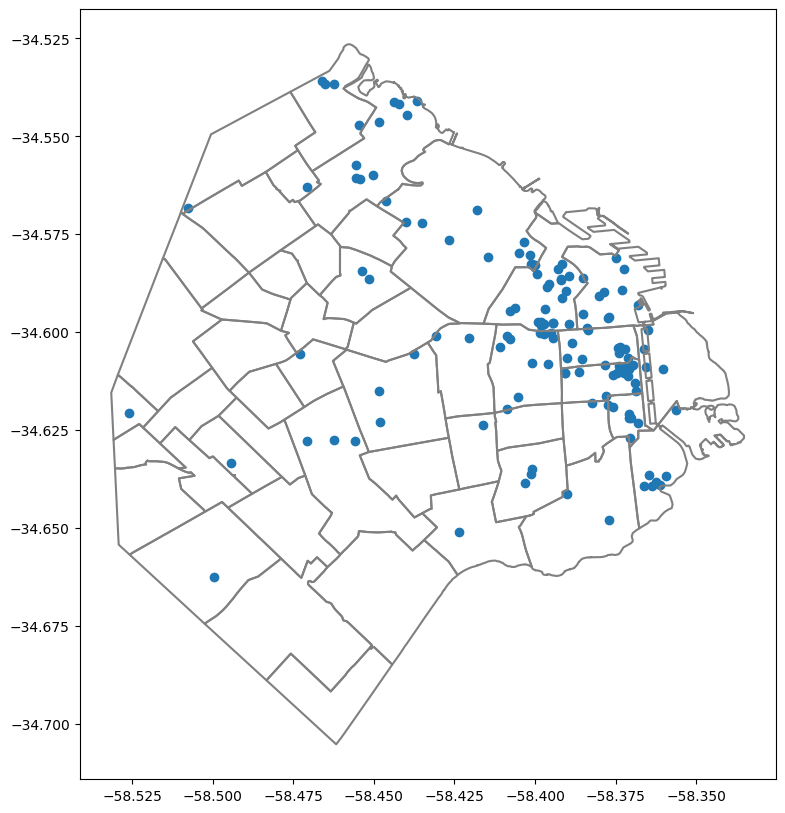

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [ ]:

m = 3 # Cantidad de links por nodo
A = tpl.construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

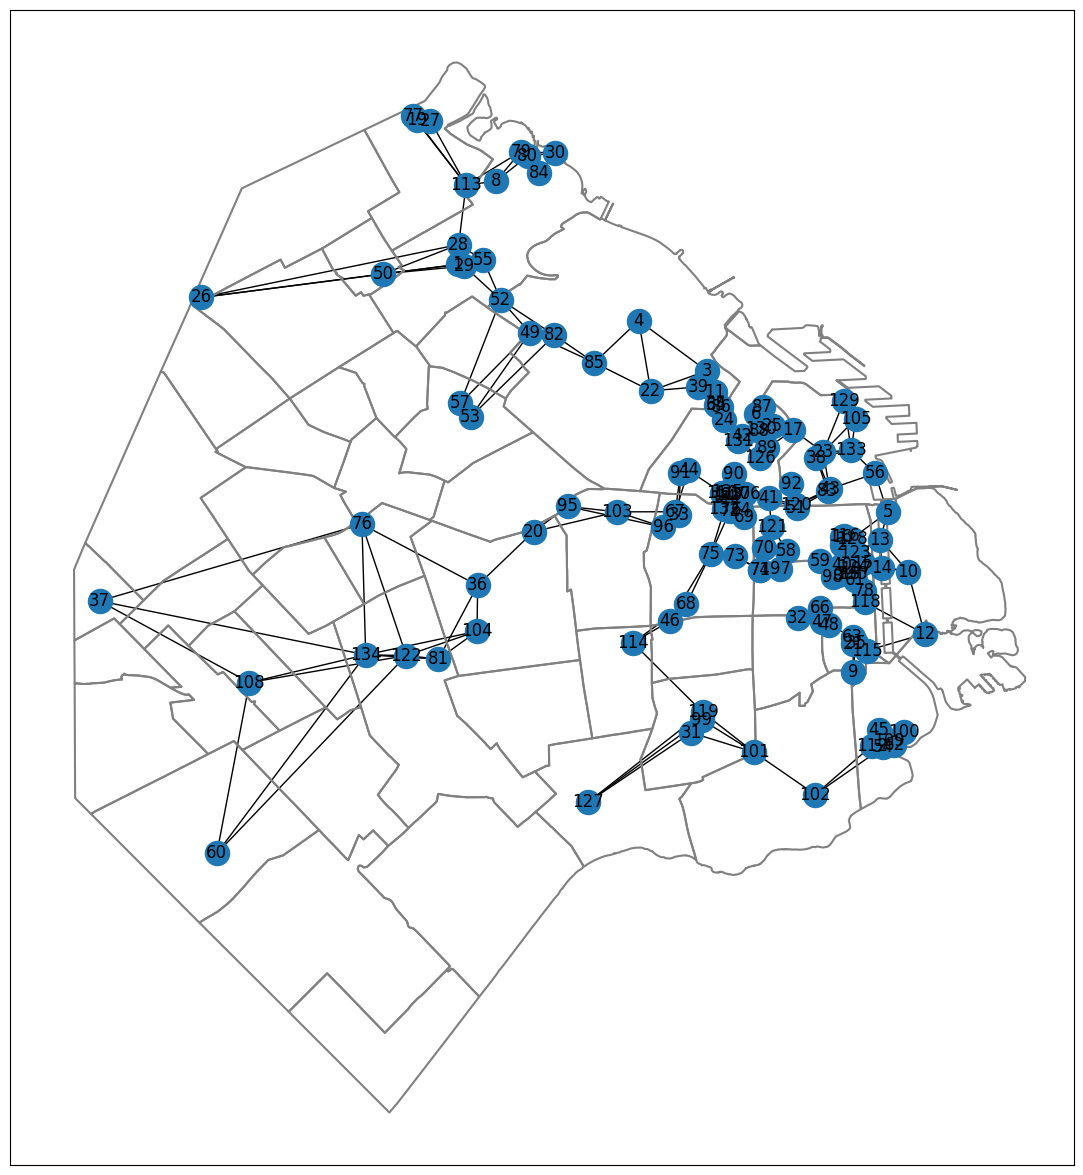

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP



**Funciones base**

### Construcción de matriz de adyacencia

In [ ]:
def construye_adyacencia(D,m):
    # Funci√≥n que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores l√≥gicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que est√©n a una distancia menor o igual a la del m-esimo m√°s cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

### Factorización LU de la matriz

In [ ]:
def calculaLU(matriz):
    # matriz es una matriz de NxN
    # Retorna la factorizaci√≥n LU a traves de una lista con dos matrices L y U de NxN.
    matriz = matriz.astype(np.float64) # Para operar con más precisión.

    n = matriz.shape[0] # n = dimensión de la matriz.

    # Si hay algún 0 en la diagonal de la matriz, imprime un mensaje de error y devuelve las matrices Identidad y matriz.
    for p in range(0, len(matriz)):
        if matriz[p][p] == 0:
            Identidad = np.eye(len(matriz))
            print("Error: hay por lo menos un cero en la diagonal.")
            return (Identidad, matriz)

    # Si la matriz es de 1x1, L=(1) y U=(a11).
    if n == 1:
        L = 1
        U = matriz[0, 0]
        return (L, U)

    U = np.zeros_like(matriz) # Creamos U, una matriz de 0s con la dimensión de la matriz.
    U[0, :] = matriz[0, :]  # Primera fila de U es igual a la primera fila de la matriz.

    L = np.eye(n) # Creamos L como la identidad nxn.
    L[1:, 0] = matriz[1:, 0] / U[0, 0] # Primera columna de L sin el primer elemento.

    # Generamos una submatriz para aplicar recursión:
    # A la matriz original le sacamos la primera fila y columna y le restamos la primera columna de la matriz L (sin el primer elemento)
    # por la primera fila de la matriz U (sin el primer elemento).
    matriz_recursiva = matriz[1:, 1:] - L[1:, 0].reshape(n - 1, 1) @ U[0, 1:].reshape(1, n - 1)

    L_recu, U_recu = calculaLU(matriz_recursiva) # Generamos el resto de los valores de L y U de forma recursiva.
    L[1:, 1:] = L_recu
    U[1:, 1:] = U_recu

    return (L, U)


In [ ]:
#Prueba primero con el ejemplo de clase
matriza = [[2, 1, -2], [4, 3, -1], [-2, 2, 13]]
df = np.array(matriza)
print(df)
LU = calculaLU(df)
print(f"L: ", LU[0])
print(f"U: ", LU[1])

[[ 2  1 -2]
 [ 4  3 -1]
 [-2  2 13]]
L:  [[ 1.  0.  0.]
 [ 2.  1.  0.]
 [-1.  3.  1.]]
U:  [[ 2.  1. -2.]
 [ 0.  1.  3.]
 [ 0.  0.  2.]]


### Cálculo matrixz C

In [ ]:
#transpuesta=que las filas sean las columnas y las columnas las filas
def trans(A):
    filas = len(A) #longitud de las filas
    columnas = len(A[0]) #longitud de las columnas
    AA = [] #matriz vacia
    for j in range(columnas):
        nueva_fila = [] #una fila vacia
        for i in range(filas):
            nueva_fila.append(A[i][j]) #le pongo lo de las columnas a las filas
        AA.append(nueva_fila) #pongo la nueva fila en una nueva matriz
    Aarray= np.asarray(AA) #convierto lista a numpy
    return Aarray

#K es una matriz de ceros que tiene en su diagonal la suma de las columnas de A
def LaK(A):
    n = A.shape[0]  #pido el numero de filas
    K = np.zeros((n, n))  #matriz de ceros segun numero de filas
    for i in range(n):
        K[i, i] = np.sum(A[i, :])  #sumo cada columna y lo pongo en la diagonal
    return K

#como K es una matriz de ceros con solo numeros en la diagonal, su inversa sera
#la misma solo que los numeros  la diagonal ahora estaran elevados a la menos uno
def diagonalalamenos1(K):
    Kinversa = K.copy() #copio K
    for i in range(K.shape[0]):
        Kinversa[i, i] = 1 / K[i, i] #le pido que la diagonal este a la menos 1
    return Kinversa

def calcula_matriz_C(A):
    Atranspuesta = trans(A) #traspongo A
    Kinv = diagonalalamenos1(LaK(A)) #saco K inv
    C = Atranspuesta@Kinv #producto matricial entre Atranspuesta y Kinv
    return C

C=calcula_matriz_C(A)
C2 = template_funciones.calcula_matriz_C(A)


In [ ]:
print(C)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Calculo PageRank

In [ ]:
def calcula_pagerank(A,alfa):
    # Funci√≥n para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el n√∫mero de museos N a partir de la estructura de la matriz A
    M = (N/alfa)*(np.eye(N) - (1-alfa)*C) #el dato de que es M, nos lo dice el enunciado del punto 1
    L, U = calculaLU(M) # Calculamos descomposici√≥n LU a partir de C y d
    b = np.ones(N) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversi√≥n usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversi√≥n usando U
    return p

### Calculo C continua

In [ ]:
def calcula_matriz_C_continua(D):
    # Funci√≥n para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versi√≥n continua
    D = D.copy()
    F = 1/D
    np.fill_diagonal(F,0) #como F en la diagonal me da infinito, reemplazo los infinitos por ceros
    KFinv = diagonalalamenos1(LaK(F)) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de F
    C =  F@KFinv # Calcula C multiplicando Kinv y F
    return C

Ccont=calcula_matriz_C_continua(D)

<ipython-input-14-2a54d13c7a33>:6: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


In [ ]:
print(Ccont)

[[0.         0.00303675 0.02011622 ... 0.00826361 0.00553176 0.0338589 ]
 [0.00119538 0.         0.00129082 ... 0.00237898 0.00660921 0.00093357]
 [0.0192172  0.00313266 0.         ... 0.01092125 0.00541689 0.01531572]
 ...
 [0.00468455 0.00342604 0.00648077 ... 0.         0.0050311  0.00378953]
 [0.00122469 0.00371719 0.00125536 ... 0.00196484 0.         0.00094881]
 [0.04248399 0.0029758  0.02011622 ... 0.00838763 0.00537734 0.        ]]


### Calculo B

In [ ]:
#hago una funcion que me da una matriz elevado al exponete (este no debe ser cero)
def elevar(matriz, exponente):
    res=matriz #matriz elevado a la uno
    for i in range(1, exponente):
        res@=matriz #y luego le multiplico a la matriz elevado a la uno lo que necesito para q este elevado a lo q yo quiero q este
    return res

#B es igual a la sumatoria de Ccontinua a la cero hasta Ccontinua elevado a cantidad_de_visitas -1 inclusive
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas
    #y el número inicial de visitantes suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    B = np.eye(C.shape[0]) #B inicialmente es una matriz elevado a la cero, lo que seria igual a Ccontinua elevado a la cero
    for i in range(1, cantidad_de_visitas):
        B+= elevar(C, i)# Sumamos las matrices de transición para cada cantidad de pasos, osea le sumamos la Ccont elevado a la uno hasta la Ccont elevado a cantidad_de_visitas -1 inclusive
    return B

B=(calcula_B(Ccont,3))

In [ ]:
print(B)

[[1.02830029 0.00906477 0.03712002 ... 0.01871298 0.01398526 0.05859437]
 [0.00356823 1.06582312 0.0037657  ... 0.00593181 0.01377948 0.00300604]
 [0.03546106 0.0091389  1.02451984 ... 0.02212063 0.01354249 0.03202599]
 ...
 [0.01060818 0.00854258 0.01312658 ... 1.00997131 0.01094079 0.00938005]
 [0.00309622 0.00774994 0.00313846 ... 0.0042728  1.00927891 0.00262936]
 [0.07352048 0.00958189 0.04206409 ... 0.02076154 0.01490187 1.05762105]]


## Punto 1:

Dado $\mathbf{p}$, el vector de rankings de tamaño N que cumple la siguiente igualdad:

$$
\mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}_N
$$

Queremos ver que el vector $\mathbf{p}$ es solución de la ecuación:

$$
M \mathbf{p} = \mathbf{b}, \quad \text{con} \quad M = \frac{N}{\alpha} \left(I - (1 - \alpha) C \right) \quad \text{y} \quad \mathbf{b} = \mathbf{1}_N.
$$

Partiendo de la ecuación:

$$
\mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}_N
$$

Podemos reordenarla como:

$$
\mathbf{p} - (1 - \alpha) C \mathbf{p} = \frac{\alpha}{N} \mathbf{1}_N
$$

Luego, factorizando $\mathbf{p}$, obtenemos:

$$
\left( I - (1 - \alpha) C \right) \mathbf{p} = \frac{\alpha}{N} \mathbf{1}_N
$$

Multiplicando ambos lados por $\frac{N}{\alpha}$, obtenemos:

$$
\frac{N}{\alpha} \left( I - (1 - \alpha) C \right) \mathbf{p} = \mathbf{1}_N
$$

Por definición de **M** y cancelando términos del lado derecho de la igualdad, obtenemos:

$$
M \mathbf{p} = \mathbf{1}_N = \mathbf{b}
$$

$\square$

## Punto 2:


Para que la ecuación lineal:

$$
Mp = b
$$

tenga una única solución, la matriz **M** debe ser inversible, lo que equivale a decir que, el único vector x  que cumple

$$
Mx = 0
$$

es el vector nulo.

Queremos ver que la matriz M tal como fue construida
para los museos, cuando 0 < α < 1 cumple con la condición anterior.

Teniendo en cuenta que **C** es una matriz de transición estocástica por columnas (es decir que cada columna suma 1), para este rango de valores de α,  $\frac{N}{\alpha}$ es siempre positivo por lo que no influye en la inversibilidad de M.

Luego, basta con demostrar que $A = I - (1 - \alpha) C$ es inversible para concluir que M también lo es (siempre tomando como hipótesis 0 < α < 1).

Supongamos que existe un vector $ x \ne 0 $ tal que:

$$
Ax = (I - (1 - \alpha)C)x = 0
$$

Entonces:

$$x - (1 - \alpha) C x = 0 \iff
x = (1 - \alpha) Cx
$$

Ahora, si aplico norma 1 de ambos lados, como C es estocástica y se cumple  que $\|C\|_1 = 1$:

$$
\|x\|_1 = \left\|(1 - \alpha) Cx\right\|_1 \iff
\|x\|_1 = |(1 - \alpha)| \left\|x\right\|_1
$$

pero como $\|x\|_1$ es una constante, obtenemos que:

$$1 = |(1 - \alpha)|$$

*Absurdo*, ya que 0 < α < 1.

Entonces, la única solución a $ Ax = 0 $ es efectivamente:

$$
x = 0
$$

Luego, A es inversible cuando 0 < α < 1, y en consecuencia, M = $\frac{N}{\alpha}A $ también lo es.

$\square$

Calculo de pagerank con m = 3 y alpha = 1/5.

Visualización con tamaño de nodos proporcional a pagerank

### Punto 3)




In [ ]:
def prcongrafico(m, alpha):
  adyacencia = construye_adyacencia(D, m)
  pagerank = calcula_pagerank(adyacencia, alpha)
  #Muestra el vector p ordenado para facilitar la visualización.
  prordenado = pd.Series(pagerank).sort_values(ascending=False)
  print("Museos más centrales: \n", prordenado.head(3))
  #display(prordenado.head(3))
  #Para el gráfico
  G = nx.from_numpy_array(adyacencia) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
  G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
  factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
  fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax); # Graficamos Los barrios
  pr = np.random.uniform(pagerank)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
  pr = pr/pr.sum() # Normalizamos para que sume 1
  Nprincipales = 5 # Cantidad de principales
  principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
  labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
  nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False); # Graficamos red
  #nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres
  return


Museos más centrales: 
 117    0.024135
125    0.023529
18     0.021281
dtype: float64


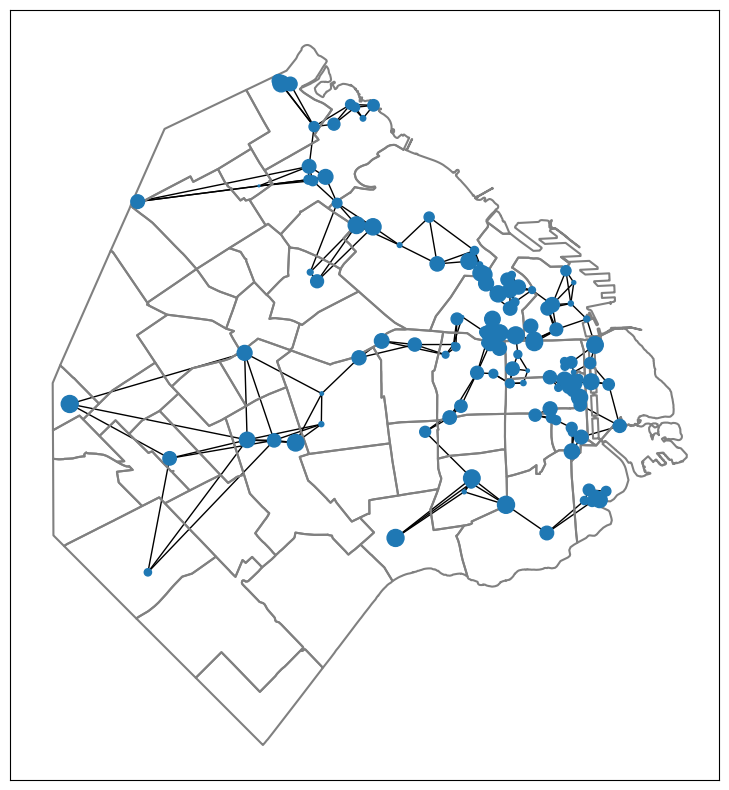

In [ ]:
prcongrafico(3, 1/5)

Podemos ver que la red se sectoriza en 3 partes, norte sur y la zona del centro.

In [ ]:
dic = template_funciones.dicPagerankSobreM(D, [1,3,5,10], 1/5)
df = pd.DataFrame(dic)



In [ ]:
#Obtengo los 3 museos centrales para cada valor de m
top3_por_m = df.groupby('m').apply(lambda g: g.nlargest(3, 'pgr'))


#Devuelve un array con los museos centrales para cada m
museos_top = top3_por_m['museo'].unique()

#Filtro el dataframe original para quedarme con todas las mediciones de los museos centrales
df_filtrado = df[df['museo'].isin(museos_top)]
df_filtrado.sort_values("museo")



<ipython-input-31-81a83e5883cf>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_por_m = df.groupby('m').apply(lambda g: g.nlargest(3, 'pgr'))


,museo,m,pgr
15,15,1,0.006459
151,15,3,0.003867
423,15,10,0.018291
287,15,5,0.010792
290,18,5,0.019526
426,18,10,0.016744
154,18,3,0.021281
18,18,1,0.009967
34,34,1,0.021288
170,34,3,0.014112


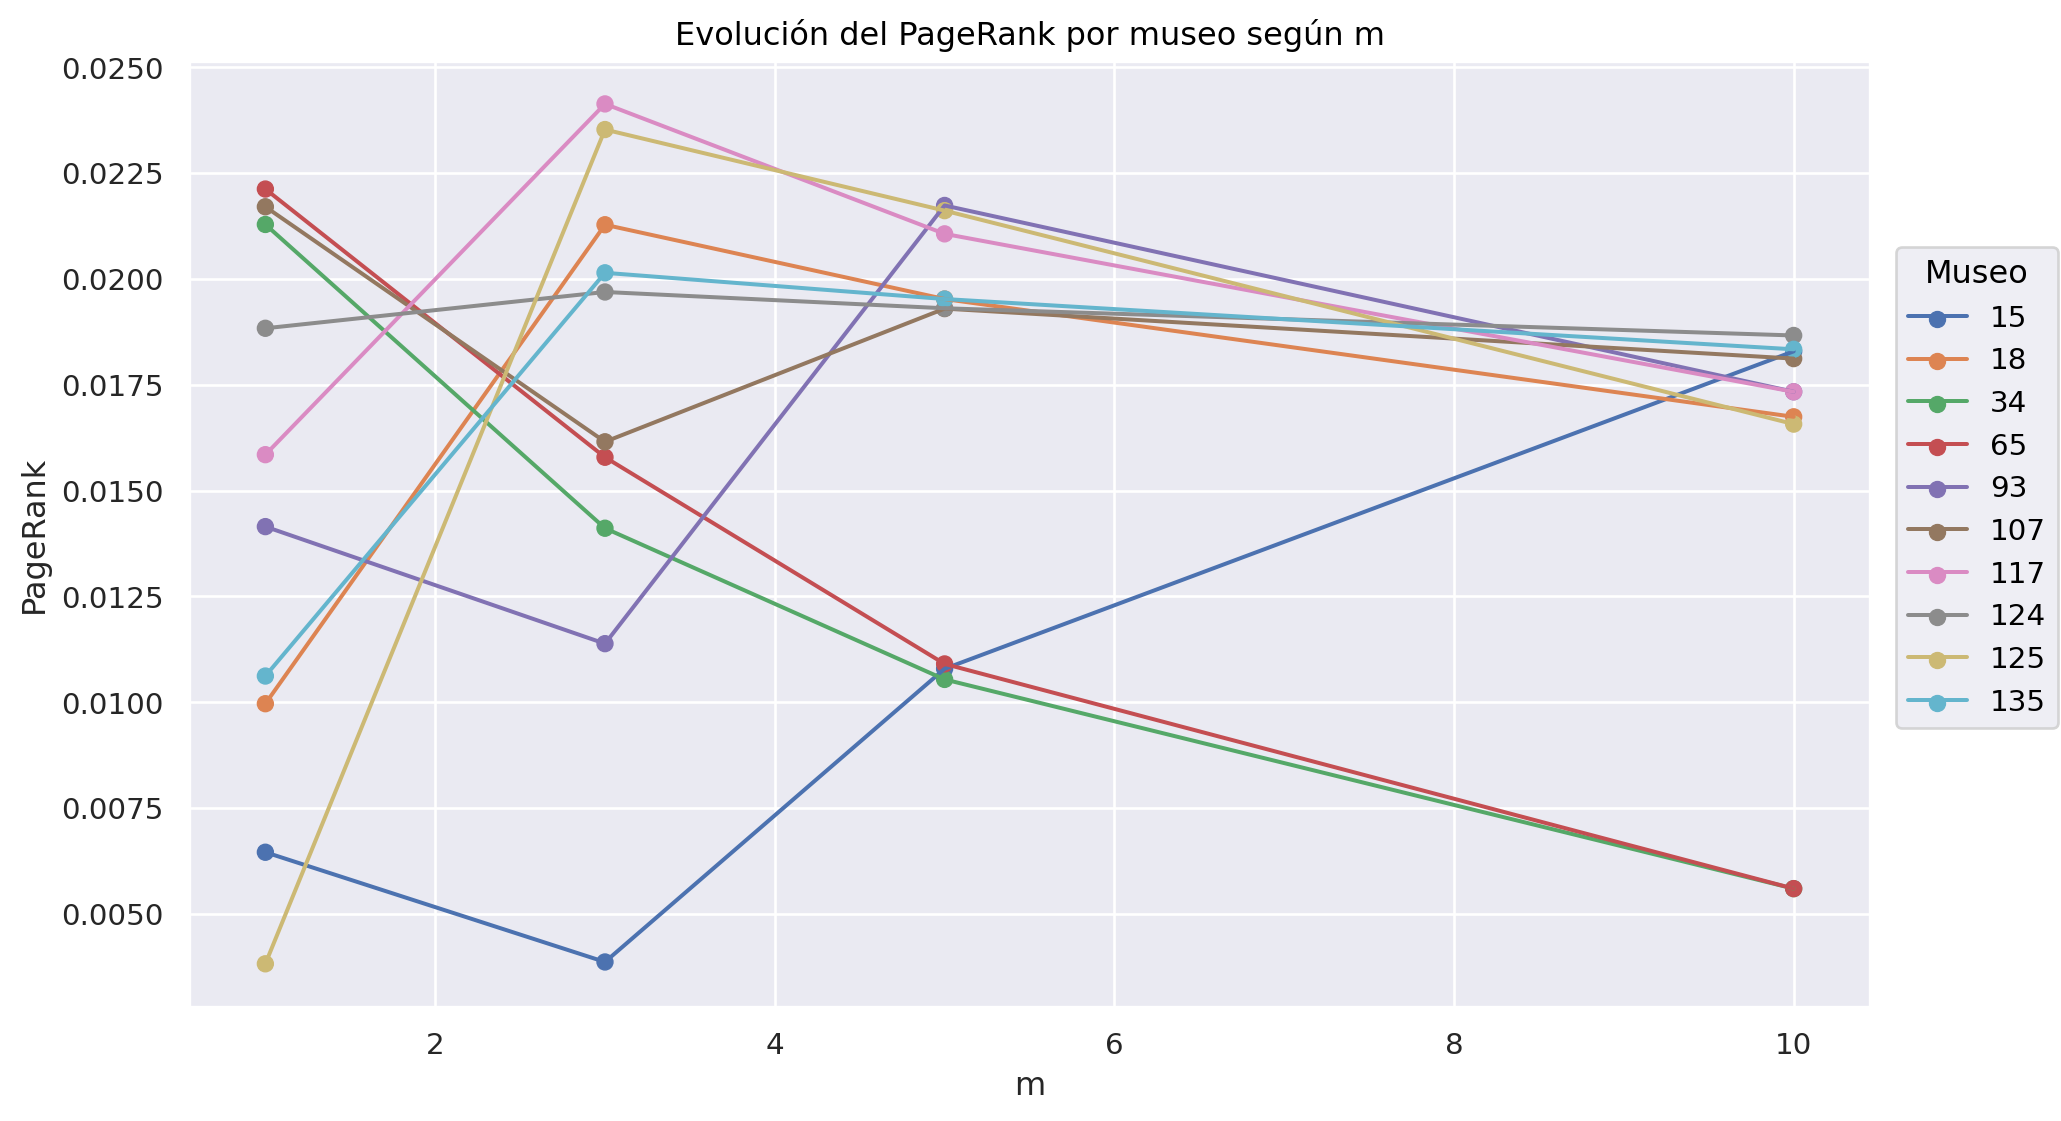

In [ ]:
#Grafico pagerank en funcion de m para cada museo, agregando un punto en el valor de m
#y separando cada museo por color
(
    so.Plot(df_filtrado, x='m', y='pgr', color='museo')
    .add(so.Line())  # Linea por cada museo
    .add(so.Dot())  # Puntos marcados (opcional)
    .label(title='Evolución del PageRank por museo según m',
           x='m', y='PageRank', color='Museo')
    .scale(color=so.Nominal())  # Asegura que los colores se asignen a categorías
    .layout(size=(10, 6))  # Tamaño del gráfico
)

In [ ]:
dic = template_funciones.dicPagerankSobreAlpha(D, 3,  [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7])
df = pd.DataFrame(dic)

In [ ]:
#Obtengo los 3 museos centrales para cada valor de alpha
top3_por_m = df.groupby('alpha').apply(lambda g: g.nlargest(3, 'pgr'))


#Devuelve un array con los museos centrales para cada m
museos_top = top3_por_m['museo'].unique()

#Filtro el dataframe original para quedarme con todos los valores de los museos centrales
df_filtrado = df[df['museo'].isin(museos_top)]
df_filtrado.sort_values("museo")

<ipython-input-40-19f34e40f4ff>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_por_m = df.groupby('alpha').apply(lambda g: g.nlargest(3, 'pgr'))


,museo,alpha,pgr
18,18,0.857143,0.008878
154,18,0.800000,0.009565
290,18,0.666667,0.011371
426,18,0.500000,0.014128
562,18,0.333333,0.017652
698,18,0.200000,0.021281
834,18,0.142857,0.023146
360,88,0.666667,0.010615
496,88,0.500000,0.012248
88,88,0.857143,0.008753


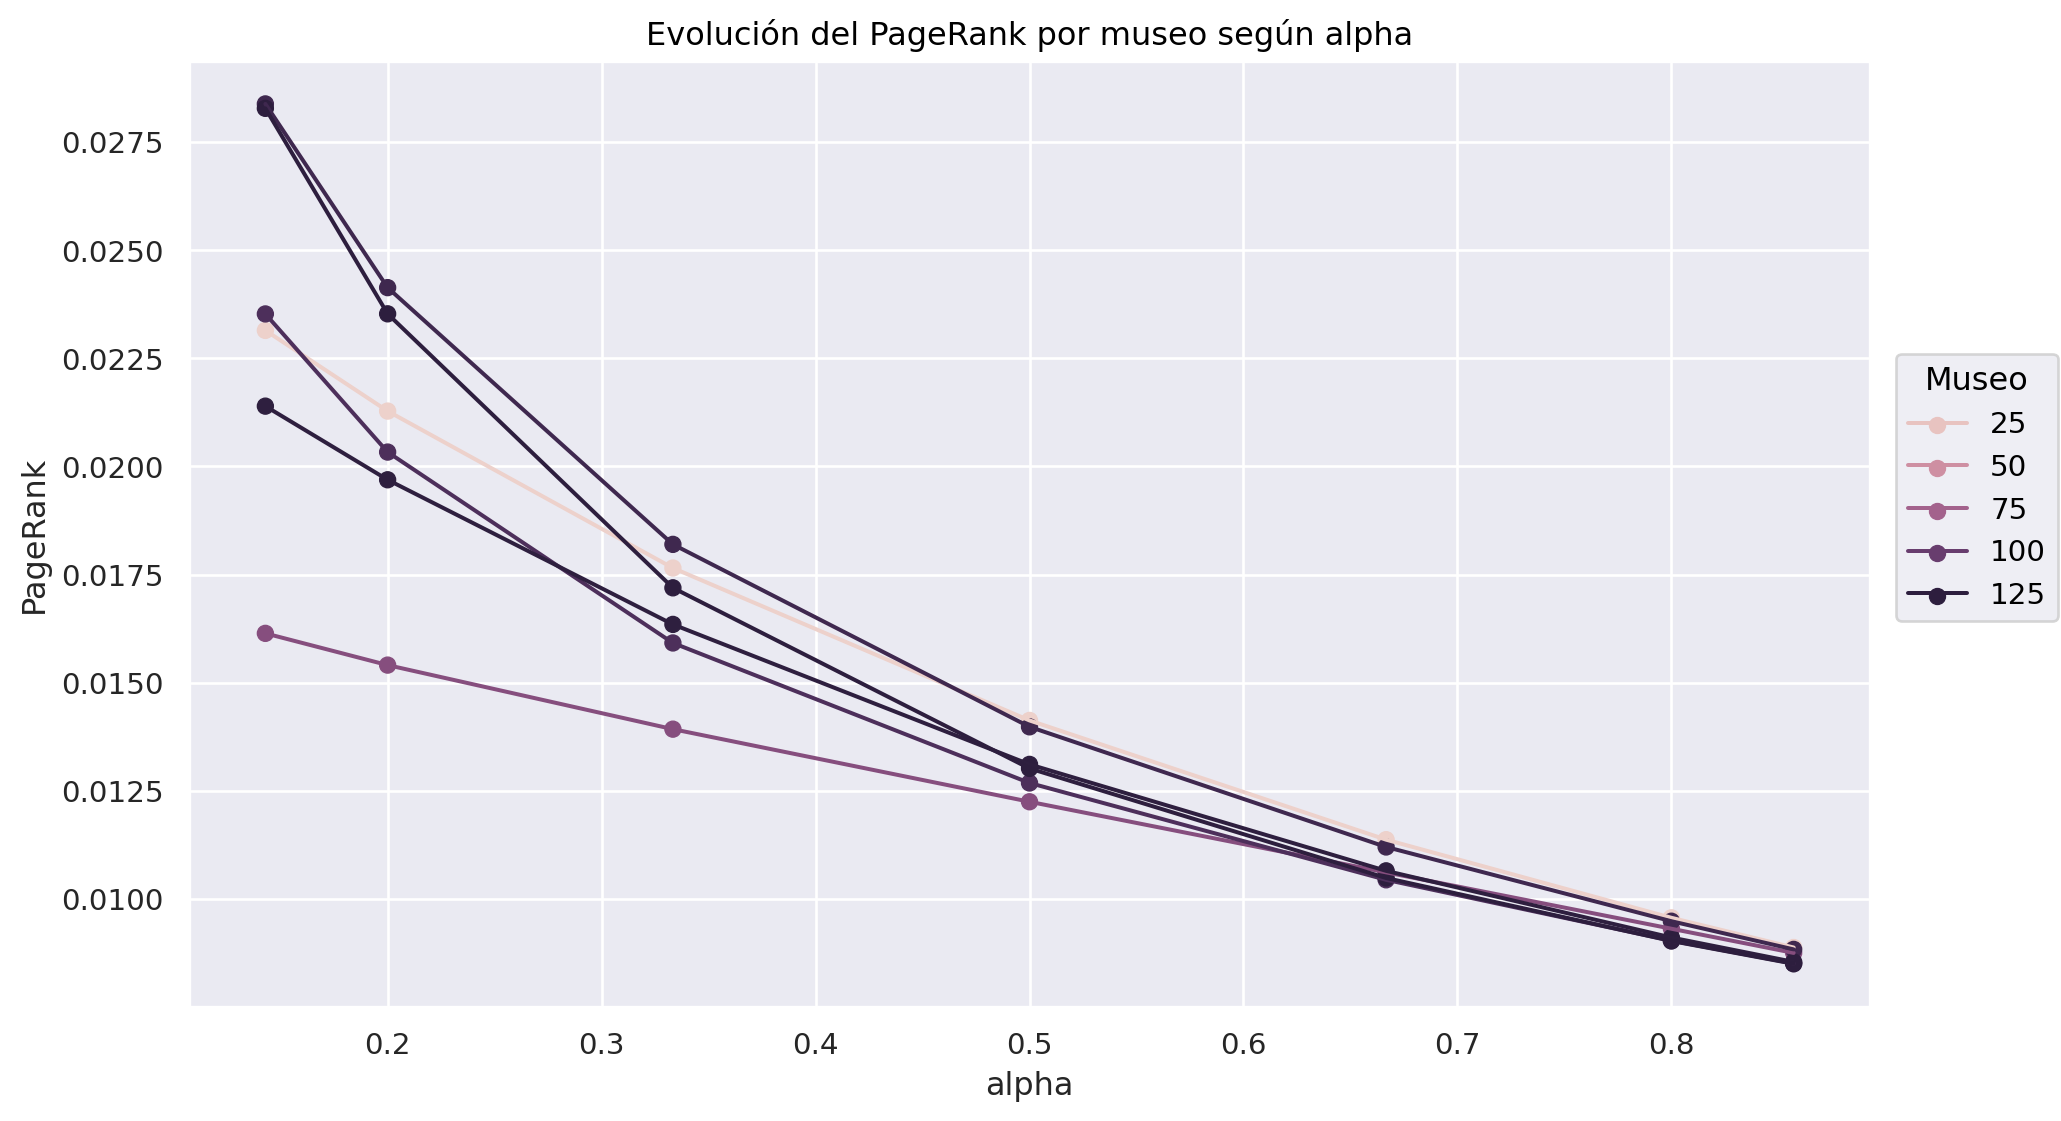

In [ ]:
(
    so.Plot(df_filtrado, x='alpha', y='pgr', color='museo')
    .add(so.Line())  # Linea por cada museo
    .add(so.Dot())  # Puntos marcados (opcional)
    .label(title='Evolución del PageRank por museo según alpha',
           x='alpha', y='PageRank', color='Museo')
    .scale(color=so.Nominal())  # Asegura que los colores se asignen a categorías
    .layout(size=(10, 6))  # Tamaño del gráfico
)

[texto del enlace](https://)
## Punto 4:

El vector v representa la cantidad de personas que entran a la red en cada museo, y luego se mueven a travez de la red usando la matriz de transiciones C.

Osea que para r = 1(primer salto) la distribución de personas en la red es:

$$
v = C^{r-1}v = C^0v
$$

Para r = 2(segundo salto) es:

$$
C^{r-1}v = Cv
$$

Para r=3 es:

$$
C^{r-1}v = C^2v
$$

Análogamente, despues de r pasos, la distribución resulta

$$
C^{r-1}v
$$

Cada una de estas distribuciones se puede sumar y acumular las visitas totales de cada museo, representadas en el vector w, osea:

$$
w = v + Cv + C^2v + ... + C^{r-1}v
$$

Despejando v:

$$
w = (1 + C + C^2 + ... + C^{r-1})v = (\sum_{k=0}^{r-1}C^k)v
$$

Luego, como $$ B= \sum_{k=0}^{r-1}C^k $$

Tengo que
$$
w=Bv
$$

Basta ver que B es inversible para despejar v.
Lo cuál es cierto, ya que se construye a partir de elevar la matriz C, que es una matriz estocástica donde todas sus entradas son positivas, y por lo tanto su suma B también. Luego,

$$
v = B^{-1}w
$$


Como quería probar.


## Punto 5:

In [ ]:
#Quiero resolver el sistema Bv=w con B=LU, osea LUv=w, siendo Uv = Y

#Sacamos L de B
BL=calculaLU(B)[0]
#Sacamos U de B
BU=calculaLU(B)[1]


#Resolvemos LY=w
Y=scipy.linalg.solve_triangular(BL, w)

#Resolvemos Uv=Y
v=scipy.linalg.solve_triangular(BU, Y)

#Y usamos esta libreria sumar el modulo de los datos de v
vtotales=np.linalg.norm(v, ord=1)
print("Visitantes Totales: ", vtotales)

Visitantes Totales:  228523.01054991985


## Punto 6:

In [ ]:
def inversa_por_LU(A):
    #Calculamos la descomposición LU.
    L = calculaLU(A)[0]
    U = calculaLU(A)[1]

    I= np.eye(len(A)) #Matriz identidad del tamaño de A.

    A_inversa = np.zeros((len(A),len(A[0]))) #Creamos una matriz Ainversa de 0s del mismo tamaño que A.

    #Cada fila de A_inversa es igual a Aei.
    i=0
    while i < len(I):
        y = scipy.linalg.solve_triangular(L,I[i], lower=True) #Resolvemos Ly=ei.
        x = scipy.linalg.solve_triangular(U,y, lower=False) #Resolvemos Ux=y.
        A_inversa[i] = x
        i = i+1

    #Devuelve la transpuesta de A_inversa (para que Aei sea cada columna).
    return(trans(A_inversa))

In [ ]:
B_inversa = inversa_por_LU(B)

In [ ]:
def norma_1(matriz):
    return np.max(np.sum(np.abs(matriz), axis=0))

In [ ]:
def numero_condicion_norma_1(matriz, inversa):
    return norma_1(matriz) * norma_1(inversa)

In [ ]:
cond_B = numero_condicion_norma_1(B, B_inversa)

print("\nNúmero de condición de B:", cond_B)


Número de condición de B: 5.051771176665006


------------------------------------------------------
Ahora, sabiendo que:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq \text{cond}_1(B) \cdot \frac{\|w - \tilde{w}\|_1}{\|w\|_1}
$$

Como el número total de visitantes $ w $ tiene un error del 5\%:

$$
\frac{\|w - \tilde{w}\|_1}{\|w\|_1} = 0.05
$$

Sumado a que el número de condición de B calculado arriba es,

$$
\text{cond}_1(B) = 5.051771176665006
$$

podemos concluir que:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq 5.051771176665006 \cdot 0.05 = 0.2525885588332503
$$

Es decir, que el error relativo en la estimación de $ v $ (redondeado) cumple la siguiente cota:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq 0.25
$$

In [ ]:
error_relativo_w = 0.05  # 5%

# Cálculo de la cota del error relativo en v
cota_error_v = cond_B * error_relativo_w

print(f"Cota para el error relativo en v: {cota_error_v:.2}.")
print(f"Cota para el error relativo en v (expresada en porcentaje): {cota_error_v:.0%}.")


Cota para el error relativo en v: 0.25.
Cota para el error relativo en v (expresada en porcentaje): 25%.


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

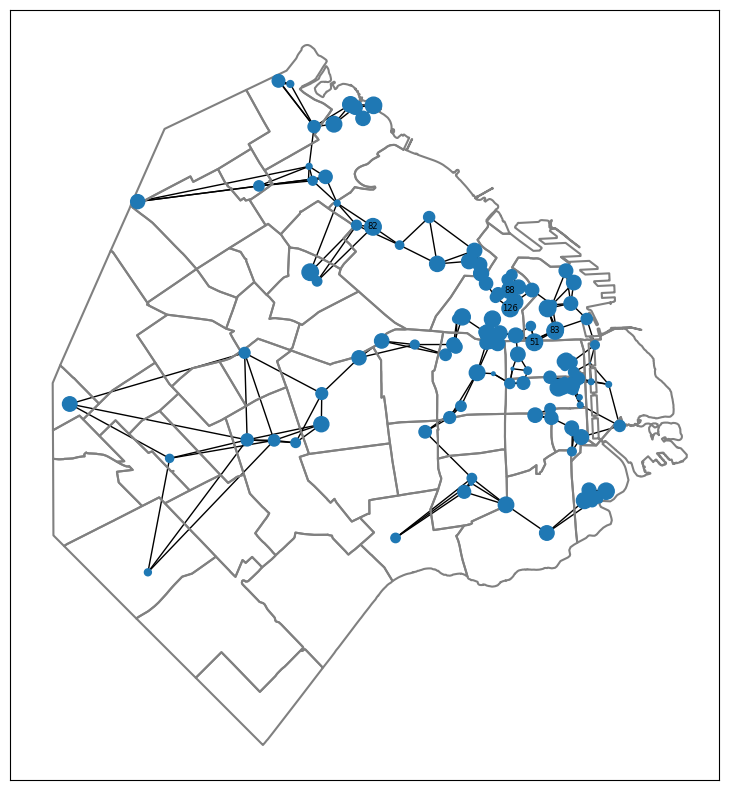

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres